## PTSBE accuracy verification: noisy-reference XEB

This notebook validates that the PTSBE (Pre-Trajectory Sampling with Batch Execution) noisy simulator produces correct measurement distributions by comparing against two independent references:

1. **Density-matrix (DM) reference** (`density-matrix-cpu`): provides exact noisy outcome probabilities $p_{\text{DM}}(x)$ via the full $2^n \times 2^n$ density matrix diagonal. Used to compute the $F_{\text{noisy}}$ metric.
2. **Standard noisy sampler** (`nvidia`): performs native per-shot trajectory simulation through `cudaq.sample()` with noise. Scored against the same DM reference as a control.

Histogram-based metrics like Hellinger fidelity break down at scale: with $D = 2^n$ possible bitstrings and a fixed shot budget $N$, most bins are empty once $n > 20$, so bin-by-bin comparisons are dominated by sampling noise. XEB avoids this by scoring each sample against the reference probability for that single outcome, giving an estimator that converges at $O(1/\sqrt{N})$ regardless of $D$. For a detailed introduction to XEB theory, see [Google's XEB tutorial](https://quantumai.google/cirq/noise/qcvv/xeb_theory).

We adapt Google's [cross-entropy benchmarking (XEB)](https://quantumai.google/cirq/noise/qcvv/xeb_theory) to work with a noisy reference distribution instead of an ideal statevector (we cannot rely on the Porter-Thomas distribution when our reference is noisy). The resulting metric, $F_{\text{noisy}}$, directly measures whether a sampler draws from the same distribution as the DM reference.

*Scalability note.* Computing $p_{\text{DM}}(x)$ requires the exact diagonal of the $2^n \times 2^n$ density matrix, which limits this approach to moderate qubit counts ($n \le 12$ on CPU). For larger simulations, a sample-only metric like [Maximum Mean Discrepancy (MMD)](https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy) can compare the two sampling distributions directly, without access to exact probabilities.

### Circuit family

We use XEB-style random circuits following Google's structure ([Arute et al., Nature 2019](https://www.nature.com/articles/s41586-019-1666-5)). Each circuit has $n$ qubits arranged in a linear chain and $m$ depth cycles. One cycle consists of:

- Single-qubit layer: A random gate from $\{\sqrt{X},\, \sqrt{Y},\, \sqrt{W}\}$ applied to each qubit, where $W = (X + Y)/\sqrt{2}$. No gate repeats on the same qubit in consecutive cycles.
- Two-qubit layer: CX (CNOT) gates in an alternating nearest-neighbor tiling (even pairs on even cycles, odd pairs on odd cycles).

This gate set produces distributions that are highly sensitive to per-gate errors, making it a strong probe for correctness. The implementation below uses the same three-gate set: $\sqrt{X} = R_x(\pi/2)$, $\sqrt{Y} = R_y(\pi/2)$, and $\sqrt{W}$ decomposed as $R_z(\pi/4)\,R_x(\pi/2)\,R_z(-\pi/4)$, with the no-consecutive-repeat constraint. CX (CNOT) substitutes for the native entangling gate.

### Deriving the metric

The linear XEB fidelity estimator from [Arute et al.](https://www.nature.com/articles/s41586-019-1666-5) ([Supplementary Information, Eq. 17](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-019-1666-5/MediaObjects/41586_2019_1666_MOESM1_ESM.pdf)) relates the experimentally observed mean of $Dp_s(q) - 1$ to the fidelity $F$ and the sum of squared ideal probabilities:

$$\overline{\langle Dp_s(q) - 1\rangle} = F \left(D\sum_q p_s(q)^2 - 1\right)$$

Solving for $F$ and writing $e_U = \sum_q p_s(q)^2$ and $\hat{m}_U = \frac{1}{N}\sum_i p_s(x_i)$:

$$F = \frac{\hat{m}_U - 1/D}{e_U - 1/D}$$

In the standard setting, $p_s = p_{\text{ideal}}$ and the Porter-Thomas distribution gives $e_U \approx 2/D$, which simplifies the above to the familiar $F = D\langle p_{\text{ideal}}(x_i)\rangle - 1$. We cannot use this simplification because our reference is a noisy mixed state whose diagonal is therefore not Porter-Thomas distributed.

We replace $p_s$ with $p_{\text{DM}}(x) = \langle x | \rho | x \rangle$, the diagonal of the density matrix from the trusted DM simulator. We then compute $e_U = \sum_x p_{\text{DM}}(x)^2$ exactly from the density matrix, with no distributional assumption:

$$Z = \sum_x p_{\text{DM}}(x)^2$$

The resulting metric is:

$$F_{\text{noisy}} = \frac{\hat{m}_U - 1/D}{Z - 1/D} = \frac{\frac{1}{N}\sum_i p_{\text{DM}}(x_i) \;-\; 1/D}{Z \;-\; 1/D} \qquad \text{where } D = 2^n$$

- $F_{\text{noisy}} = 1.0$: the PTSBE samples reproduce the exact noisy distribution ($\hat{m}_U = Z$, i.e. the cross-correlation with the reference equals the reference's self-score).
- $F_{\text{noisy}} = 0.0$: the PTSBE samples are indistinguishable from uniform ($\hat{m}_U = 1/D$).

### Protocol

For a random circuit $C$ drawn from the family above:

1. **Reference probabilities**: Run $C$ with noise on `density-matrix-cpu`. Extract the diagonal of the final density matrix to get $p_{\text{DM}}(x)$ for all $x \in \{0,1\}^n$. Apply classical readout noise to match the measurement channel. Compute $Z = \sum_x p_{\text{DM}}(x)^2$.
2. **Sample**: Run the same noisy circuit via both `cudaq.sample()` on cusvsim (control) and `cudaq.ptsbe.sample()` (test) to produce $N$ samples each.
3. **Score**: For each sampler, compute $\hat{m}_U = \frac{1}{N}\sum_i p_{\text{DM}}(x_i)$ and $F_{\text{noisy}} = (\hat{m}_U - 1/D) / (Z - 1/D)$. Both should be $\approx 1.0$.

In [1]:
import os, sys
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["CUDAQ_PTSBE_FORCE_GENERIC"] = "1"

# TODO: Remove this sys.path override before pushing the PR.
sys.path.insert(0, os.path.expanduser(
    "~/Devel/cudaq-pstbe/vendor/cuda-quantum/build/python"))

import cudaq
import numpy as np
import time
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (8, 4),
    "axes.grid": True,
    "grid.alpha": 0.3,
})

print(f"cudaq loaded from: {cudaq.__path__[0]}")
assert hasattr(cudaq, "ptsbe"), "cudaq.ptsbe not found -- is the build current?"

DM_TARGET = "density-matrix-cpu"

# GPU state-vector target backed by cusvsim (cuStateVec).
# cusvsim supports native per-shot trajectory noise simulation, so the same
# backend serves both roles: PTSBE uses it for individual trajectory
# state-vector evolution, and the standard sampler uses it for direct
# noisy cudaq.sample().
GPU_TARGET = "nvidia"
try:
    cudaq.set_target(GPU_TARGET)
except Exception:
    GPU_TARGET = "qpp-cpu"

PTSBE_TARGET = GPU_TARGET
STD_TARGET = GPU_TARGET

cudaq.set_target(DM_TARGET)
cudaq.set_random_seed(42)
print(f"GPU target:  {GPU_TARGET}")
print(f"DM target:   {DM_TARGET}")

cudaq loaded from: /home/talexander/Devel/cudaq-pstbe/vendor/cuda-quantum/build/python/cudaq
GPU target:  nvidia
DM target:   density-matrix-cpu


### Single-circuit walkthrough

We walk through the full protocol on one fixed circuit ($n=8$, $m=8$), introducing each utility function as we need it.

**Circuit construction.** `generate_gate_choices` draws gate IDs from $\{\sqrt{X},\, \sqrt{Y},\, \sqrt{W}\}$ with a no-consecutive-repeat constraint. `build_xeb_circuit` assembles cycles of the chosen single-qubit gates followed by a nearest-neighbor CNOT chain. Pass `with_mz=False` for `get_state()` (no measurement collapse) and `with_mz=True` for `sample()`.

In [2]:
XEB_GATE_IDS = [0, 1, 2]  # sqrt(X), sqrt(Y), sqrt(W)


def generate_gate_choices(n, depth, rng):
    """Generate per-qubit gate choices for an XEB circuit.

    Returns an (n, depth) array of gate IDs from {0, 1, 2} corresponding to
    {sqrt(X), sqrt(Y), sqrt(W)}.  Consecutive layers on the same qubit are
    guaranteed to use different gates (matching the Arute et al. constraint).
    """
    choices = np.empty((n, depth), dtype=int)
    choices[:, 0] = rng.choice(XEB_GATE_IDS, size=n)
    for d in range(1, depth):
        for i in range(n):
            prev = choices[i, d - 1]
            choices[i, d] = rng.choice([g for g in XEB_GATE_IDS if g != prev])
    return choices


def _apply_xeb_gate(kernel, qubit, gate_id):
    """Apply one of {sqrt(X), sqrt(Y), sqrt(W)} to a qubit.

    sqrt(X) = Rx(pi/2), sqrt(Y) = Ry(pi/2).
    sqrt(W) with W = (X+Y)/sqrt(2) is a pi/2 rotation around the (1,1,0)
    axis, decomposed as Rz(pi/4) Rx(pi/2) Rz(-pi/4).
    """
    if gate_id == 0:
        kernel.rx(np.pi / 2, qubit)
    elif gate_id == 1:
        kernel.ry(np.pi / 2, qubit)
    else:
        kernel.rz(np.pi / 4, qubit)
        kernel.rx(np.pi / 2, qubit)
        kernel.rz(-np.pi / 4, qubit)


def build_xeb_circuit(n, depth, gate_choices, with_mz=True):
    """Build an XEB circuit following Arute et al. (2019).

    Single-qubit layer: one of {sqrt(X), sqrt(Y), sqrt(W)} per qubit,
    drawn with no consecutive repeats on any qubit.
    Two-qubit layer: CX ladder across nearest neighbours.
    """
    kernel = cudaq.make_kernel()
    q = kernel.qalloc(n)
    for d in range(depth):
        for i in range(n):
            _apply_xeb_gate(kernel, q[i], int(gate_choices[i, d]))
        for i in range(n - 1):
            kernel.cx(q[i], q[i + 1])
    if with_mz:
        kernel.mz(q)
    return kernel


rng = np.random.default_rng(0)
test_choices = generate_gate_choices(n=3, depth=2, rng=rng)
test_kernel = build_xeb_circuit(3, 2, test_choices)
counts = cudaq.sample(test_kernel, shots_count=1000)
print(f"3-qubit, depth-2 circuit (no noise): {len(counts)} unique bitstrings from 1000 shots")
print(counts)

3-qubit, depth-2 circuit (no noise): 8 unique bitstrings from 1000 shots
{ 000:32 001:36 010:39 011:28 100:198 101:235 110:224 111:208 }



**Noise model.** PTSBE requires unitary-mixture noise channels (each Kraus operator is a scaled Pauli unitary). `build_noise_model` applies symmetric Pauli noise on single-qubit gates ($X/Y/Z$ each at $p_1/3$), two-qubit gates (15-term Pauli at $p_2/15$ each), and bit-flip readout error ($p_{\text{meas}}$).

In [3]:
def build_noise_model(p1=0.001, p2=0.01, p_meas=0.01):
    """Build a Pauli noise model with measurement readout error.

    PTSBE requires unitary-mixture channels. Pauli channels satisfy this:
    each Kraus operator is a Pauli unitary scaled by sqrt(p).
    """
    noise = cudaq.NoiseModel()
    pauli1 = cudaq.Pauli1([p1 / 3] * 3)
    noise.add_all_qubit_channel('rx', pauli1)
    noise.add_all_qubit_channel('ry', pauli1)
    noise.add_all_qubit_channel('cx', cudaq.Pauli2([p2 / 15] * 15))
    noise.add_all_qubit_channel('mz', cudaq.BitFlipChannel(p_meas))
    return noise


noise_model = build_noise_model()
noisy_counts = cudaq.sample(test_kernel, noise_model=noise_model, shots_count=1000)
print(f"Same circuit with Pauli noise (p1=0.001, p2=0.01, p_meas=0.01):")
print(f"  {len(noisy_counts)} unique bitstrings from 1000 shots")
print(noisy_counts)

Same circuit with Pauli noise (p1=0.001, p2=0.01, p_meas=0.01):
  8 unique bitstrings from 1000 shots
{ 000:42 001:46 010:35 011:42 100:217 101:224 110:197 111:197 }



#### Density matrix reference

We build both kernel variants (with and without measurement) from the same gate choices up front, ensuring both simulators run the exact same circuit. `get_dm_diagonal` takes the measurement-free kernel, runs it on `density-matrix-cpu` with noise, and extracts the diagonal $p_{\text{DM}}(x) = \langle x|\rho|x\rangle$.

In [4]:
def _bit_reverse_permutation(n):
    """Return index array that maps MSB-ordered diagonal to LSB ordering."""
    D = 2 ** n
    return np.array([int(f"{i:0{n}b}"[::-1], 2) for i in range(D)])


def apply_readout_noise(probs, n, p_meas):
    """Apply per-qubit bit-flip measurement noise to a probability vector.

    For each qubit, independently flips the measurement outcome with
    probability p_meas.  This is the classical stochastic map
    [[1-p, p], [p, 1-p]] applied along each qubit axis.
    """
    if p_meas <= 0:
        return probs.copy()
    p = probs.reshape([2] * n).copy()
    for q in range(n):
        p0 = np.take(p, 0, axis=q)
        p1 = np.take(p, 1, axis=q)
        new_p0 = (1 - p_meas) * p0 + p_meas * p1
        new_p1 = p_meas * p0 + (1 - p_meas) * p1
        idx0 = [slice(None)] * n
        idx0[q] = 0
        idx1 = [slice(None)] * n
        idx1[q] = 1
        p[tuple(idx0)] = new_p0
        p[tuple(idx1)] = new_p1
    return p.flatten()


def get_dm_diagonal(kernel, noise_model, n, p_meas=0.0):
    """Run DM simulation with noise and return the diagonal probabilities.

    The density-matrix-cpu target (QPP) uses MSB qubit ordering. We permute
    the diagonal to LSB ordering so indices match cudaq.sample() bitstrings.
    If p_meas > 0, per-qubit bit-flip readout noise is applied classically.
    """
    cudaq.set_target(DM_TARGET)
    cudaq.set_noise(noise_model)
    state = cudaq.get_state(kernel)
    cudaq.unset_noise()
    dm = np.array(state)
    diag = np.real(np.diag(dm))
    probs = diag[_bit_reverse_permutation(n)]
    if p_meas > 0:
        probs = apply_readout_noise(probs, n, p_meas)
    return probs


n, depth = 8, 8
rng = np.random.default_rng(42)
gate_choices = generate_gate_choices(n, depth, rng)
noise_model = build_noise_model()
D = 2 ** n

kernel_no_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=False)
kernel_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=True)

p_dm = get_dm_diagonal(kernel_no_mz, noise_model, n, p_meas=0.01)
Z = np.sum(p_dm ** 2)
print(f"Circuit: n={n}, depth={depth}")
print(f"D = 2^{n} = {D}")
print(f"Z = sum p_DM(x)^2 = {Z:.6e}")
print(f"Uniform baseline 1/D = {1.0/D:.6e}")
print(f"Z - 1/D = {Z - 1.0/D:.6e}")
top5_idx = np.argsort(p_dm)[::-1][:5]
print("Top 5 p_DM(x):")
for idx in top5_idx:
    print(f"  {idx:0{n}b}  {p_dm[idx]:.6e}")

Circuit: n=8, depth=8
D = 2^8 = 256
Z = sum p_DM(x)^2 = 5.043771e-03
Uniform baseline 1/D = 3.906250e-03
Z - 1/D = 1.137521e-03
Top 5 p_DM(x):
  11010111  1.433727e-02
  10111111  1.295116e-02
  00110110  1.104876e-02
  00101110  1.069331e-02
  10100111  1.046053e-02


#### Noisy sampling

`run_noisy_sample` abstracts over the sampling backend. Both methods use the same GPU simulator (cusvsim) but through different code paths:

- `method="standard"`: `cudaq.sample()` on `STD_TARGET`. cusvsim performs native per-shot trajectory simulation internally.
- `method="ptsbe"`: `cudaq.ptsbe.sample()` on `PTSBE_TARGET`. PTSBE pre-generates a set of Kraus trajectories, then dispatches batched state-vector simulations on cusvsim.

Any difference in $F_{\text{noisy}}$ quantifies PTSBE's approximation error from trajectory truncation.

In [5]:
MULT_ALLOC = cudaq.ptsbe.ShotAllocationStrategy(
    type=cudaq.ptsbe.ShotAllocationType.MULTIPLICITY_WEIGHTED)


def run_noisy_sample(kernel, noise_model, shots, method="ptsbe",
                     max_traj=1000, seed=42):
    """Sample a noisy circuit using either exact noisy simulation or PTSBE.

    method="standard" -- cudaq.sample() with noise on STD_TARGET
    method="ptsbe"    -- cudaq.ptsbe.sample() on PTSBE_TARGET
    """
    if method == "standard":
        cudaq.set_target(STD_TARGET)
        return cudaq.sample(kernel, noise_model=noise_model, shots_count=shots)
    elif method == "ptsbe":
        cudaq.set_target(PTSBE_TARGET)
        strategy = cudaq.ptsbe.ProbabilisticSamplingStrategy(seed=seed)
        return cudaq.ptsbe.sample(
            kernel, noise_model=noise_model, shots_count=shots,
            sampling_strategy=strategy, max_trajectories=max_traj,
            shot_allocation=MULT_ALLOC,
        )
    else:
        raise ValueError(f"Unknown method: {method}")


N = 100_000
for method in ["standard", "ptsbe"]:
    result = run_noisy_sample(kernel_mz, noise_model, shots=N, method=method)
    top5 = sorted(result.items(), key=lambda kv: kv[1], reverse=True)[:5]
    print(f"{method:>8s}: {len(result)} unique bitstrings, "
          f"top 5: {[(bs, c) for bs, c in top5]}")

standard: 256 unique bitstrings, top 5: [('11010111', 1432), ('10111111', 1271), ('00101110', 1088), ('00110110', 1064), ('10100111', 1022)]
   ptsbe: 256 unique bitstrings, top 5: [('11010111', 1343), ('10111111', 1324), ('00110110', 1085), ('00101110', 1035), ('01101100', 1012)]


#### Scoring

`compute_f_noisy` looks up $p_{\text{DM}}(x_i)$ for each sampled bitstring, computes the mean $\hat{m}_U$, and returns $F_{\text{noisy}} = (\hat{m}_U - 1/D) / (Z - 1/D)$. We score both `standard` (cusvsim trajectory simulation) and `ptsbe` side-by-side. `standard` should produce $F_{\text{noisy}} \approx 1.0$; PTSBE may show values slightly above 1.0 due to trajectory truncation bias (see **Trajectory convergence** in the calibration section).

In [6]:
def compute_f_noisy(p_dm, result, n):
    """Compute noisy-reference XEB fidelity F_noisy."""
    D = 2 ** n
    N = result.get_total_shots()
    Z = np.sum(p_dm ** 2)
    e = sum(count * p_dm[int(bs, 2)] for bs, count in result.items()) / N
    f = (e - 1.0 / D) / (Z - 1.0 / D)
    return f, e, Z


N = 100_000
print(f"A/B comparison (n={n}, depth={depth}, N={N} shots):\n")
for method in ["standard", "ptsbe"]:
    result = run_noisy_sample(kernel_mz, noise_model, shots=N, method=method)
    f, e, _ = compute_f_noisy(p_dm, result, n)
    top5 = sorted(result.items(), key=lambda kv: kv[1], reverse=True)[:5]
    print(f"  {method:>8s}: F_noisy = {f:.4f}, E = {e:.6e}")
    print(f"            top 5: {[(bs, c) for bs, c in top5]}")

A/B comparison (n=8, depth=8, N=100000 shots):

  standard: F_noisy = 0.9978, E = 5.041234e-03
            top 5: [('11010111', 1437), ('10111111', 1312), ('00110110', 1119), ('10100111', 1081), ('00101110', 1064)]
     ptsbe: F_noisy = 1.0008, E = 5.044634e-03
            top 5: [('11010111', 1450), ('10111111', 1423), ('00110110', 1118), ('00101110', 1063), ('10100111', 1015)]


### Calibration

Before generating the main validation plots, we calibrate two parameters ($n=8$, depth $=8$). Both use a self-contained variance criterion: the coefficient of variation $\text{CV} = \sigma / |\bar{F}|$ across multiple repeats. Each repeat uses a **different random circuit** so that the CV captures cross-circuit variance (the realistic operating regime), not just trajectory-seed variance on a single circuit. We select the smallest budget where $\text{CV}$ falls below 1%, indicating stable run-to-run behavior. No comparison against the standard simulator is needed during calibration; the A/B comparison happens in the downstream validation plots.

1. **Trajectory budget** (`MAX_TRAJ`): sweep `max_trajectories` with multiple repeats (each on a different circuit). Select the first budget where $\text{CV} < 1\%$. Cap at 5,000 if no point qualifies.
2. **Shot budget** (`N_SHOTS`): sweep $N$ with multiple repeats (each on a different circuit). Select the first $N$ where $\text{CV} < 1\%$. Cap at 500,000 if no point qualifies.

The selected values flow into all downstream sweeps as `MAX_TRAJ` and `N_SHOTS`.

### Trajectory convergence

$F_{\text{noisy}}$ vs `max_trajectories` for fixed total shots. Each repeat uses a different random circuit ($n=8$, depth $=8$) so that the CV reflects realistic cross-circuit variance. As the trajectory budget increases, PTSBE captures more of the total probability mass $P_S = \sum_{k \in S} p_k$ and $F_{\text{noisy}}$ converges toward $\approx 1.0$. When $P_S < 1$, the selected (predominantly low-error) trajectories receive more weight than they should, making the output distribution artificially sharp and driving $F_{\text{noisy}} > 1$.

To compare shot allocation strategies, each trajectory budget is evaluated under both `MULTIPLICITY_WEIGHTED` and `PROPORTIONAL` allocation. We run multiple repeats (each on a distinct circuit) and compute the coefficient of variation $\text{CV} = \sigma / |\bar{F}|$: a low CV indicates stable behavior across circuits. We select the first budget where $\text{CV} < 1\%$ using `MULTIPLICITY_WEIGHTED`, which remains the core strategy for all downstream analyses.

In [7]:
n, depth = 8, 8
N = 100_000
noise_model = build_noise_model()
n_traj_repeats = 5

rep_circuits = []
for rep in range(n_traj_repeats):
    rng = np.random.default_rng(200 + rep)
    gc = generate_gate_choices(n, depth, rng)
    k_no_mz = build_xeb_circuit(n, depth, gc, with_mz=False)
    k_mz = build_xeb_circuit(n, depth, gc, with_mz=True)
    p = get_dm_diagonal(k_no_mz, noise_model, n, p_meas=0.01)
    rep_circuits.append((k_mz, p))

traj_counts = [25, 50, 100, 250, 500, 1000, 2000, 5000, 10000, 50000, 100000]
TRAJ_MAX_CAP = 5_000
TRAJ_CV_THRESHOLD = 0.01  # 1% coefficient of variation

alloc_strategies = {
    "mult_weighted": cudaq.ptsbe.ShotAllocationType.MULTIPLICITY_WEIGHTED,
    "proportional":  cudaq.ptsbe.ShotAllocationType.PROPORTIONAL,
}

traj_results = {}
for alloc_name, alloc_type in alloc_strategies.items():
    data = {"f_mean": [], "f_std": [], "cv": [], "n_traj": [], "pcap": [], "mt_used": []}
    print(f"\n--- Shot allocation: {alloc_name} ---")
    print(f"Trajectory convergence (n={n}, depth={depth}, N={N:,}, repeats={n_traj_repeats})\n")
    print(f"{'max_traj':>10s}  {'n_traj':>8s}  {'P_captured':>10s}  {'F_mean':>8s}  {'F_std':>8s}  {'CV':>8s}")
    for mt in traj_counts:
        f_values = []
        n_traj_values = []
        pcap_values = []
        for rep in range(n_traj_repeats):
            kernel_mz_rep, p_dm_rep = rep_circuits[rep]
            cudaq.set_target(PTSBE_TARGET)
            strategy = cudaq.ptsbe.ProbabilisticSamplingStrategy(seed=42 + rep)
            alloc = cudaq.ptsbe.ShotAllocationStrategy(type=alloc_type)
            try:
                result = cudaq.ptsbe.sample(
                    kernel_mz_rep, noise_model=noise_model, shots_count=N,
                    sampling_strategy=strategy, max_trajectories=mt,
                    shot_allocation=alloc,
                    return_execution_data=True,
                )
            except RuntimeError as exc:
                print(f"{mt:>10d}  {'FAIL':>8s} (rep {rep}): {exc}")
                continue
            trajs = result.ptsbe_execution_data.trajectories
            pcap_values.append(sum(t.probability for t in trajs))
            n_traj_values.append(len(trajs))
            f, _, _ = compute_f_noisy(p_dm_rep, result, n)
            f_values.append(f)
        if not f_values:
            continue
        fm = np.mean(f_values)
        fs = np.std(f_values)
        cv = fs / abs(fm) if abs(fm) > 0 else float('inf')
        n_traj_avg = int(np.mean(n_traj_values))
        p_cap_avg = np.mean(pcap_values)
        data["f_mean"].append(fm)
        data["f_std"].append(fs)
        data["cv"].append(cv)
        data["n_traj"].append(n_traj_avg)
        data["pcap"].append(p_cap_avg)
        data["mt_used"].append(mt)
        print(f"{mt:>10d}  {n_traj_avg:>8d}  {p_cap_avg:>10.6f}  {fm:>8.4f}  {fs:>8.4f}  {cv:>8.4f}")
    traj_results[alloc_name] = data

primary = traj_results["mult_weighted"]
_selected_traj = None
for mt, cv_val in zip(primary["mt_used"], primary["cv"]):
    if cv_val < TRAJ_CV_THRESHOLD:
        _selected_traj = mt
        break

if _selected_traj is None:
    _selected_traj = TRAJ_MAX_CAP
    print(f"\n  ** No sweep point with CV < {TRAJ_CV_THRESHOLD:.0%} (mult_weighted).")
    print(f"  -> Capping MAX_TRAJ = {_selected_traj}")
else:
    print(f"\n  -> Selected MAX_TRAJ = {_selected_traj}"
          f"  (first mult_weighted with CV < {TRAJ_CV_THRESHOLD:.0%})")


--- Shot allocation: mult_weighted ---
Trajectory convergence (n=8, depth=8, N=100,000, repeats=5)

  max_traj    n_traj  P_captured    F_mean     F_std        CV
        25        25    0.500067    0.9286    0.0581    0.0626
        50        50    0.509498    0.9475    0.0233    0.0246
       100       100    0.534501    0.9904    0.0437    0.0441
       250       250    0.577673    0.9956    0.0082    0.0083
       500       500    0.628566    0.9971    0.0134    0.0134
      1000      1000    0.709736    0.9955    0.0135    0.0135
      2000      2000    0.805837    1.0026    0.0132    0.0132
      5000      5000    0.846319    0.9982    0.0064    0.0064
     10000     10000    0.850038    1.0001    0.0079    0.0079
     50000     50000    0.867760    1.0001    0.0063    0.0063
    100000    100000    0.880509    1.0058    0.0119    0.0118

--- Shot allocation: proportional ---
Trajectory convergence (n=8, depth=8, N=100,000, repeats=5)

  max_traj    n_traj  P_captured    F_mean 

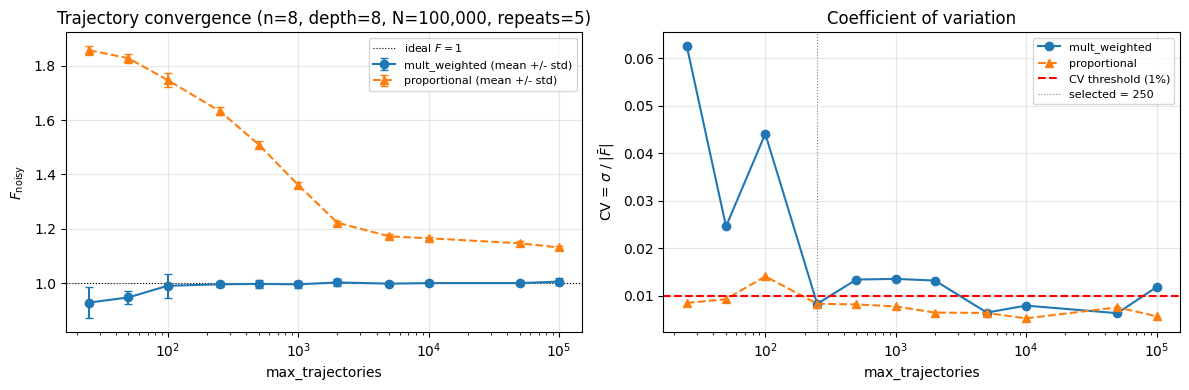

In [8]:
alloc_styles = {
    "mult_weighted": {"fmt": "o-", "color": "C0", "label": "mult_weighted"},
    "proportional":  {"fmt": "^--", "color": "C1", "label": "proportional"},
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for name, style in alloc_styles.items():
    d = traj_results[name]
    ax1.errorbar(d["mt_used"], d["f_mean"], yerr=d["f_std"],
                 fmt=style["fmt"], color=style["color"], capsize=3,
                 label=f"{style['label']} (mean +/- std)")
ax1.axhline(1.0, color="k", ls=":", lw=0.8, label="ideal $F = 1$")
ax1.set_xscale("log")
ax1.set_xlabel("max_trajectories")
ax1.set_ylabel("$F_{\\mathrm{noisy}}$")
ax1.set_title(f"Trajectory convergence (n={n}, depth={depth}, N={N:,}, repeats={n_traj_repeats})")
ax1.legend(fontsize=8)

for name, style in alloc_styles.items():
    d = traj_results[name]
    ax2.semilogx(d["mt_used"], d["cv"], style["fmt"], color=style["color"],
                 label=style["label"])
ax2.axhline(TRAJ_CV_THRESHOLD, color="r", ls="--",
            label=f"CV threshold ({TRAJ_CV_THRESHOLD:.0%})")
if _selected_traj is not None and _selected_traj != TRAJ_MAX_CAP:
    ax2.axvline(_selected_traj, color="gray", ls=":", lw=0.8,
                label=f"selected = {_selected_traj}")
ax2.set_xlabel("max_trajectories")
ax2.set_ylabel("CV = $\\sigma \\;/\\; |\\bar{F}|$")
ax2.set_title("Coefficient of variation")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

### Shot convergence

$F_{\text{noisy}}$ vs number of shots $N$ using the trajectory budget selected above. Each repeat uses a different random circuit, so CV captures cross-circuit variance. Error bars show run-to-run variation across repeats.

Both `MULTIPLICITY_WEIGHTED` and `PROPORTIONAL` shot allocation strategies are evaluated for comparison. We use the coefficient of variation $\text{CV} = \sigma / |\bar{F}|$ as a self-contained stability criterion. The first $N$ where $\text{CV}$ falls below 1% is selected using `MULTIPLICITY_WEIGHTED`, the core strategy. Cap at 500,000 if no point qualifies.

In [9]:
n, depth = 8, 8
max_traj = _selected_traj
noise_model = build_noise_model()
n_repeats = 5

shot_rep_circuits = []
for rep in range(n_repeats):
    rng = np.random.default_rng(300 + rep)
    gc = generate_gate_choices(n, depth, rng)
    k_no_mz = build_xeb_circuit(n, depth, gc, with_mz=False)
    k_mz = build_xeb_circuit(n, depth, gc, with_mz=True)
    p = get_dm_diagonal(k_no_mz, noise_model, n, p_meas=0.01)
    shot_rep_circuits.append((k_mz, p))

shot_counts = [1_000, 5_000, 10_000, 50_000, 100_000, 500_000]
SHOTS_MAX_CAP = 500_000
SHOTS_CV_THRESHOLD = 0.01   # 1% coefficient of variation

alloc_strategies = {
    "mult_weighted": cudaq.ptsbe.ShotAllocationType.MULTIPLICITY_WEIGHTED,
    "proportional":  cudaq.ptsbe.ShotAllocationType.PROPORTIONAL,
}

shot_results = {}
for alloc_name, alloc_type in alloc_strategies.items():
    data = {"f_mean": [], "f_std": [], "cv": [], "shot_counts": []}
    print(f"\n--- Shot allocation: {alloc_name} ---")
    print(f"Shot convergence (n={n}, depth={depth}, max_traj={max_traj}, repeats={n_repeats})\n")
    print(f"{'N':>10s} {'F_mean':>8s} {'F_std':>8s} {'CV':>8s}")
    for N in shot_counts:
        f_values = []
        for rep in range(n_repeats):
            kernel_mz_rep, p_dm_rep = shot_rep_circuits[rep]
            cudaq.set_target(PTSBE_TARGET)
            strategy = cudaq.ptsbe.ProbabilisticSamplingStrategy(seed=42 + rep)
            alloc = cudaq.ptsbe.ShotAllocationStrategy(type=alloc_type)
            try:
                result = cudaq.ptsbe.sample(
                    kernel_mz_rep, noise_model=noise_model, shots_count=N,
                    sampling_strategy=strategy, max_trajectories=max_traj,
                    shot_allocation=alloc,
                    return_execution_data=True,
                )
            except RuntimeError as exc:
                print(f"{N:>10d}  {'FAIL':>8s} (rep {rep}): {exc}")
                continue
            f, _, _ = compute_f_noisy(p_dm_rep, result, n)
            f_values.append(f)
        if not f_values:
            continue
        fm = np.mean(f_values)
        fs = np.std(f_values)
        cv = fs / abs(fm) if abs(fm) > 0 else float('inf')
        data["f_mean"].append(fm)
        data["f_std"].append(fs)
        data["cv"].append(cv)
        data["shot_counts"].append(N)
        print(f"{N:>10d} {fm:>8.4f} {fs:>8.4f} {cv:>8.4f}")
    shot_results[alloc_name] = data

primary = shot_results["mult_weighted"]
_selected_shots = None
for sc, cv_val in zip(primary["shot_counts"], primary["cv"]):
    if cv_val < SHOTS_CV_THRESHOLD:
        _selected_shots = sc
        break

if _selected_shots is None:
    _selected_shots = SHOTS_MAX_CAP
    print(f"\n  ** No sweep point with CV < {SHOTS_CV_THRESHOLD:.0%} (mult_weighted).")
    print(f"  -> Capping N_SHOTS = {_selected_shots:,}")
else:
    print(f"\n  -> Selected N_SHOTS = {_selected_shots:,}"
          f"  (first mult_weighted with CV < {SHOTS_CV_THRESHOLD:.0%})")


--- Shot allocation: mult_weighted ---
Shot convergence (n=8, depth=8, max_traj=250, repeats=5)

         N   F_mean    F_std       CV
      1000   1.0338   0.0389   0.0376
      5000   0.9868   0.0280   0.0284
     10000   0.9737   0.0188   0.0194
     50000   1.0062   0.0242   0.0241
    100000   0.9986   0.0162   0.0162
    500000   0.9970   0.0175   0.0175

--- Shot allocation: proportional ---
Shot convergence (n=8, depth=8, max_traj=250, repeats=5)

         N   F_mean    F_std       CV
      1000   1.7068   0.0717   0.0420
      5000   1.6418   0.0456   0.0278
     10000   1.6449   0.0124   0.0075
     50000   1.6455   0.0179   0.0109
    100000   1.6360   0.0092   0.0056
    500000   1.6363   0.0073   0.0044

  ** No sweep point with CV < 1% (mult_weighted).
  -> Capping N_SHOTS = 500,000


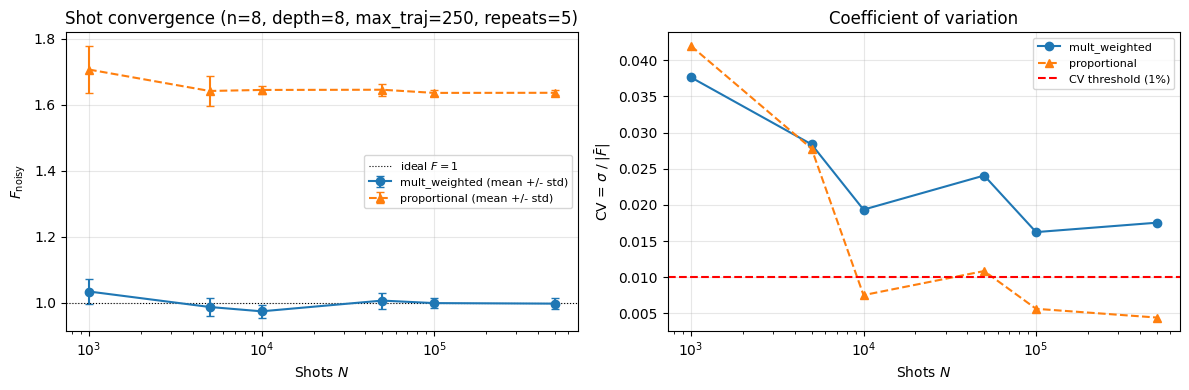

In [10]:
alloc_styles = {
    "mult_weighted": {"fmt": "o-", "color": "C0", "label": "mult_weighted"},
    "proportional":  {"fmt": "^--", "color": "C1", "label": "proportional"},
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for name, style in alloc_styles.items():
    d = shot_results[name]
    ax1.errorbar(d["shot_counts"], d["f_mean"], yerr=d["f_std"],
                 fmt=style["fmt"], color=style["color"], capsize=3,
                 label=f"{style['label']} (mean +/- std)")
ax1.axhline(1.0, color="k", ls=":", lw=0.8, label="ideal $F = 1$")
ax1.set_xscale("log")
ax1.set_xlabel("Shots $N$")
ax1.set_ylabel("$F_{\\mathrm{noisy}}$")
ax1.set_title(f"Shot convergence (n={n}, depth={depth}, max_traj={max_traj}, repeats={n_repeats})")
ax1.legend(fontsize=8)

for name, style in alloc_styles.items():
    d = shot_results[name]
    ax2.semilogx(d["shot_counts"], d["cv"], style["fmt"], color=style["color"],
                 label=style["label"])
ax2.axhline(SHOTS_CV_THRESHOLD, color="r", ls="--",
            label=f"CV threshold ({SHOTS_CV_THRESHOLD:.0%})")
if _selected_shots is not None and _selected_shots != SHOTS_MAX_CAP:
    ax2.axvline(_selected_shots, color="gray", ls=":", lw=0.8,
                label=f"selected = {_selected_shots:,}")
ax2.set_xlabel("Shots $N$")
ax2.set_ylabel("CV = $\\sigma \\;/\\; |\\bar{F}|$")
ax2.set_title("Coefficient of variation")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [11]:
MAX_TRAJ = _selected_traj
N_SHOTS = _selected_shots
print(f"Calibrated parameters for all subsequent sections:")
print(f"  MAX_TRAJ = {MAX_TRAJ}")
print(f"  N_SHOTS  = {N_SHOTS:,}")

Calibrated parameters for all subsequent sections:
  MAX_TRAJ = 250
  N_SHOTS  = 500,000


---

## PTSBE validation results

All sections below use the calibrated `MAX_TRAJ` and `N_SHOTS` selected above. If the threshold was not met within the sweep range, the parameter is capped at its maximum value and downstream results should be interpreted with that residual bias in mind.

### Width/depth correctness sweep

$F_{\text{noisy}}$ vs depth for each width, using the calibrated `MAX_TRAJ` and `N_SHOTS`. The `standard` sampler should produce values tightly clustered near 1.0. PTSBE values may show slight bias from trajectory truncation.

The CPU density-matrix simulator stores a $2^n \times 2^n$ complex matrix, so practical limits are $n = 10$-$12$. The full test suite (in CI) should use $n$ up to 24 with GPU-backed simulation.

In [12]:
widths = [4, 6, 8, 10]
depths = [2, 4, 8]
n_instances = 5
N = N_SHOTS
methods = ["standard", "ptsbe"]

sweep_results = {m: {} for m in methods}
rng = np.random.default_rng(42)

for n in widths:
    noise_model = build_noise_model()
    for depth in depths:
        f_by_method = {m: [] for m in methods}
        for inst in range(n_instances):
            gate_choices = generate_gate_choices(n, depth, rng)
            k_no_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=False)
            k_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=True)
            p_dm = get_dm_diagonal(k_no_mz, noise_model, n, p_meas=0.01)
            for m in methods:
                result = run_noisy_sample(k_mz, noise_model,
                                          shots=N, max_traj=MAX_TRAJ, method=m)
                f, _, _ = compute_f_noisy(p_dm, result, n)
                f_by_method[m].append(f)
        parts = []
        for m in methods:
            mean_f = np.mean(f_by_method[m])
            std_f = np.std(f_by_method[m])
            sweep_results[m][(n, depth)] = (mean_f, std_f)
            parts.append(f"{m}={mean_f:.4f}+/-{std_f:.4f}")
        print(f"n={n:2d}, depth={depth:2d}:  {',  '.join(parts)}")

print()
for m in methods:
    vals = np.array([v[0] for v in sweep_results[m].values()])
    print(f"{m}: mean={vals.mean():.4f}, std={vals.std():.4f}, "
          f"range=[{vals.min():.4f}, {vals.max():.4f}]")
std_ok = all(abs(v[0] - 1.0) < 0.05 for v in sweep_results["standard"].values())
print(f"\nstandard: all |F-1| < 0.05: {std_ok}")

n= 4, depth= 2:  standard=0.9997+/-0.0012,  ptsbe=1.0075+/-0.0039
n= 4, depth= 4:  standard=0.9999+/-0.0011,  ptsbe=0.9976+/-0.0024
n= 4, depth= 8:  standard=1.0007+/-0.0022,  ptsbe=1.0021+/-0.0051
n= 6, depth= 2:  standard=0.9992+/-0.0020,  ptsbe=0.9987+/-0.0031
n= 6, depth= 4:  standard=1.0002+/-0.0014,  ptsbe=1.0115+/-0.0060
n= 6, depth= 8:  standard=1.0015+/-0.0013,  ptsbe=1.0057+/-0.0037
n= 8, depth= 2:  standard=1.0005+/-0.0010,  ptsbe=0.9972+/-0.0047
n= 8, depth= 4:  standard=1.0014+/-0.0022,  ptsbe=0.9770+/-0.0043
n= 8, depth= 8:  standard=1.0001+/-0.0019,  ptsbe=0.9774+/-0.0075
n=10, depth= 2:  standard=1.0010+/-0.0012,  ptsbe=0.9952+/-0.0058
n=10, depth= 4:  standard=0.9999+/-0.0018,  ptsbe=0.9501+/-0.0061
n=10, depth= 8:  standard=0.9980+/-0.0036,  ptsbe=0.9867+/-0.0063

standard: mean=1.0002, std=0.0009, range=[0.9980, 1.0015]
ptsbe: mean=0.9922, std=0.0165, range=[0.9501, 1.0115]

standard: all |F-1| < 0.05: True


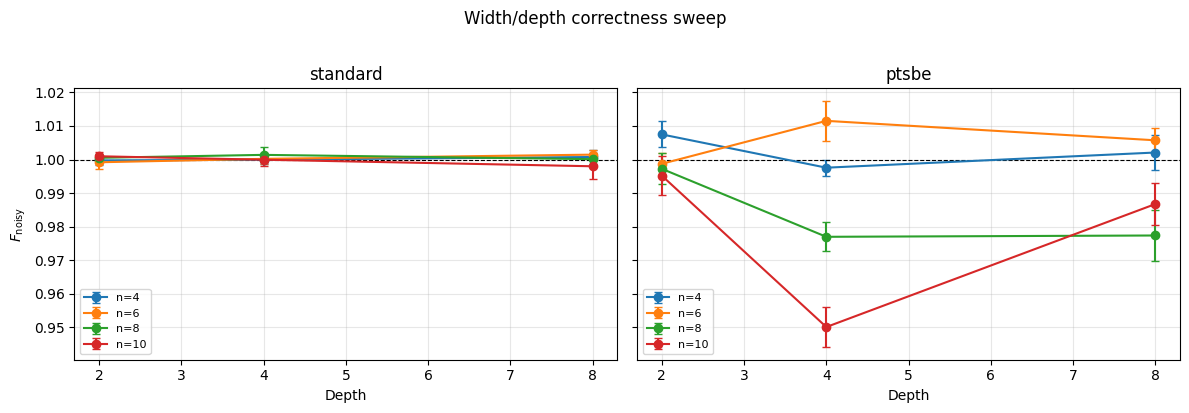

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, method in zip(axes, ["standard", "ptsbe"]):
    for w in widths:
        ds = [d for d in depths if (w, d) in sweep_results[method]]
        means = [sweep_results[method][(w, d)][0] for d in ds]
        stds = [sweep_results[method][(w, d)][1] for d in ds]
        ax.errorbar(ds, means, yerr=stds, marker="o", capsize=3, label=f"n={w}")
    ax.axhline(1.0, color="k", ls="--", lw=0.8)
    ax.set_xlabel("Depth")
    ax.set_title(method)
    ax.legend(fontsize=8)
axes[0].set_ylabel("$F_{\\mathrm{noisy}}$")
fig.suptitle("Width/depth correctness sweep", y=1.02)
plt.tight_layout()
plt.show()

### Performance comparison

Wall-clock time vs number of shots for a fixed circuit. Both methods use the `nvidia` GPU backend (cusvsim). PTSBE uses the generic per-trajectory path, which calls `custatevecSampler` (all shots in one GPU call) per trajectory.

At low shot counts, the overhead of sequentially simulating `max_trajectories` circuits dominates. At high shot counts, PTSBE's $O(\text{max\_trajectories})$ circuit simulations plus $O(1)$-per-trajectory sampling wins over the standard path's $O(N_{\text{shots}})$ trajectory simulations.

**Optimization opportunity.** Combining batched circuit simulation (parallel trajectory execution on GPU) with multi-shot `custatevecSampler` measurement would give the best of both regimes.

In [25]:
n, depth = 10, 8
rng = np.random.default_rng(600)
gate_choices = generate_gate_choices(n, depth, rng)
noise_model = build_noise_model()
kernel_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=True)

perf_shots = [1_000, 10_000, 100_000, 1_000_000]
perf_times = {"standard": [], "ptsbe (generic)": [], "ptsbe (batched)": []}

print(f"Performance comparison (n={n}, depth={depth}, max_traj={MAX_TRAJ})")
header = f"{'Shots':>10s}  {'Std (s)':>10s}  {'Generic (s)':>12s}  {'Batched (s)':>12s}  {'Speedup':>8s}"
print(header)

for N in perf_shots:
    t0 = time.perf_counter()
    run_noisy_sample(kernel_mz, noise_model, shots=N, method="standard")
    t_std = time.perf_counter() - t0

    # Generic path: per-trajectory custatevecSampler (multi-shot)
    os.environ["CUDAQ_PTSBE_FORCE_GENERIC"] = "1"
    t0 = time.perf_counter()
    run_noisy_sample(kernel_mz, noise_model, shots=N, max_traj=MAX_TRAJ, method="ptsbe")
    t_generic = time.perf_counter() - t0

    # Batched path: batchMeasure (per-shot GPU loop)
    os.environ["CUDAQ_PTSBE_FORCE_GENERIC"] = "0"
    t0 = time.perf_counter()
    run_noisy_sample(kernel_mz, noise_model, shots=N, max_traj=MAX_TRAJ, method="ptsbe")
    t_batched = time.perf_counter() - t0

    perf_times["standard"].append(t_std)
    perf_times["ptsbe (generic)"].append(t_generic)
    perf_times["ptsbe (batched)"].append(t_batched)
    speedup = t_std / t_generic if t_generic > 0 else float('inf')
    print(f"{N:>10d}  {t_std:>10.3f}  {t_generic:>12.3f}  {t_batched:>12.3f}  {speedup:>7.1f}x")

os.environ["CUDAQ_PTSBE_FORCE_GENERIC"] = "1"

Performance comparison (n=10, depth=8, max_traj=250)
     Shots     Std (s)   Batched (s)   Sampler (s)   Speedup
      1000       0.104         0.176         0.183      0.6x
     10000       0.239         0.418         0.432      0.6x
    100000       1.713         3.059         3.115      0.5x
   1000000      13.331        30.524        31.656      0.4x


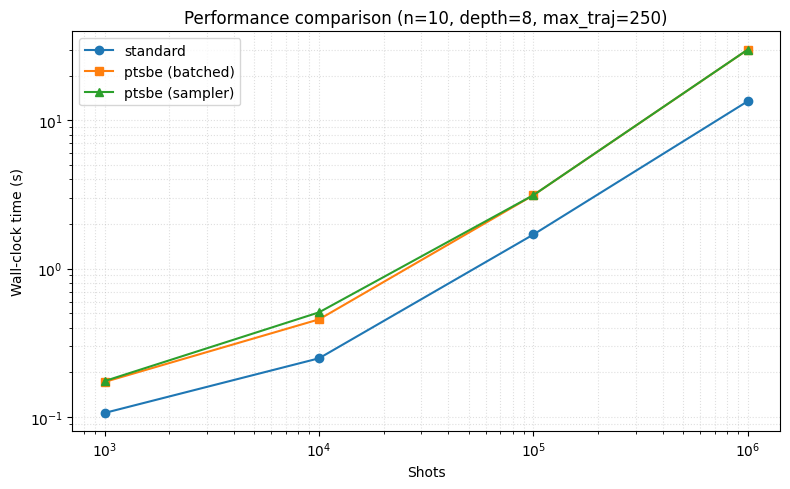

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
for method, marker in [("standard", "o"), ("ptsbe", "s")]:
    ax.loglog(perf_shots, perf_times[method], f"{marker}-", label=method)
ax.set_xlabel("Shots")
ax.set_ylabel("Wall-clock time (s)")
ax.set_title(f"Performance comparison (n={n}, depth={depth}, max_traj={MAX_TRAJ})")
ax.legend()
ax.grid(True, which="both", ls=":", alpha=0.4)
plt.tight_layout()
plt.show()

### Summary

Aggregate $F_{\text{noisy}}$ statistics from the width/depth sweep using the calibrated `MAX_TRAJ` and `N_SHOTS`.

F_noisy distribution across all (n, depth) pairs:

  standard:
    Mean:   1.0002
    Std:    0.0009
    Range:  [0.9980, 1.0015]
  ptsbe:
    Mean:   0.9922
    Std:    0.0165
    Range:  [0.9501, 1.0115]


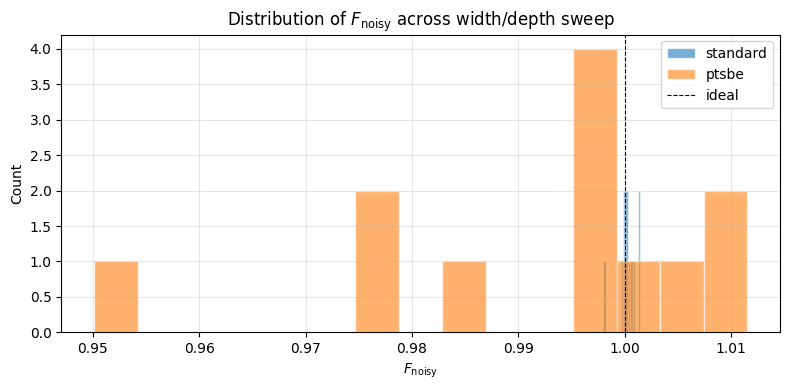

In [18]:
print("F_noisy distribution across all (n, depth) pairs:\n")
for method in ["standard", "ptsbe"]:
    vals = [v[0] for v in sweep_results[method].values()]
    f_arr = np.array(vals)
    print(f"  {method}:")
    print(f"    Mean:   {f_arr.mean():.4f}")
    print(f"    Std:    {f_arr.std():.4f}")
    print(f"    Range:  [{f_arr.min():.4f}, {f_arr.max():.4f}]")

fig, ax = plt.subplots()
for method in ["standard", "ptsbe"]:
    vals = [v[0] for v in sweep_results[method].values()]
    ax.hist(vals, bins=15, alpha=0.6, label=method, edgecolor="white")
ax.axvline(1.0, color="k", ls="--", lw=0.8, label="ideal")
ax.set_xlabel("$F_{\\mathrm{noisy}}$")
ax.set_ylabel("Count")
ax.set_title("Distribution of $F_{\\mathrm{noisy}}$ across width/depth sweep")
ax.legend()
plt.tight_layout()
plt.show()

---

## Metric validation

The sections above establish that PTSBE produces correct noisy distributions. The sections below validate the $F_{\text{noisy}}$ metric itself: that it remains stable across noise regimes (noise strength sweep) and has discriminating power (negative control).

### Noise strength sweep

$F_{\text{noisy}}$ vs single-qubit error rate $p_1$ for a fixed circuit ($n=8$, depth $=6$, $p_2 = 10\,p_1$, $p_{\text{meas}} = p_2$). Both simulators use the same noise at each rate.

$F_{\text{noisy}}$ remains near 1.0 at low noise but collapses at high noise. Looking at the metric metric:

$$F_{\text{noisy}} = \frac{\hat{e} - 1/D}{Z - 1/D}, \quad \hat{e} = \frac{1}{N}\sum_{i=1}^{N} p_{\text{DM}}(x_i), \quad Z = \sum_x p_{\text{DM}}(x)^2$$

As noise increases, $p_{\text{DM}}(x) \to 1/D$ for all $x$, so both the numerator and the denominator vanish. In theory the ratio stays well-defined, but sampling noise in $\hat{e}$ gets amplified by the vanishing denominator, making the estimator ill-conditioned. The right panel shows $Z - 1/D$ vs $p_1$ to make the breakdown threshold visible.

In [21]:
n, depth = 8, 6
rng = np.random.default_rng(500)
gate_choices = generate_gate_choices(n, depth, rng)
kernel_no_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=False)
kernel_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=True)

p1_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

D = 2**n
noise_sweep = {m: [] for m in ["standard", "ptsbe"]}
z_values = []
print(f"Noise strength sweep (n={n}, depth={depth}, N={N_SHOTS:,})")
for p1 in p1_values:
    p2 = p1 * 10
    p_meas = p2
    noise_model = build_noise_model(p1=p1, p2=p2, p_meas=p_meas)
    p_dm = get_dm_diagonal(kernel_no_mz, noise_model, n, p_meas=p_meas)
    parts = []
    for method in ["standard", "ptsbe"]:
        result = run_noisy_sample(kernel_mz, noise_model,
                                  shots=N_SHOTS, max_traj=MAX_TRAJ, method=method)
        f, _, Z = compute_f_noisy(p_dm, result, n)
        noise_sweep[method].append(f)
        parts.append(f"{method}={f:.4f}")
    z_values.append(Z)
    print(f"  p1={p1:.4f}:  {',  '.join(parts)}  (Z={Z:.6e}, Z-1/D={Z - 1/D:.2e})")

Noise strength sweep (n=8, depth=6, N=500,000)
  p1=0.0001:  standard=0.9988,  ptsbe=1.0030  (Z=7.569858e-03, Z-1/D=3.66e-03)
  p1=0.0005:  standard=1.0022,  ptsbe=0.9871  (Z=6.470826e-03, Z-1/D=2.56e-03)
  p1=0.0010:  standard=0.9987,  ptsbe=0.9928  (Z=5.574924e-03, Z-1/D=1.67e-03)
  p1=0.0050:  standard=0.9818,  ptsbe=1.0152  (Z=4.014222e-03, Z-1/D=1.08e-04)
  p1=0.0100:  standard=0.9579,  ptsbe=0.6973  (Z=3.916303e-03, Z-1/D=1.01e-05)
  p1=0.0500:  standard=0.1473,  ptsbe=0.2403  (Z=3.906250e-03, Z-1/D=-5.59e-17)


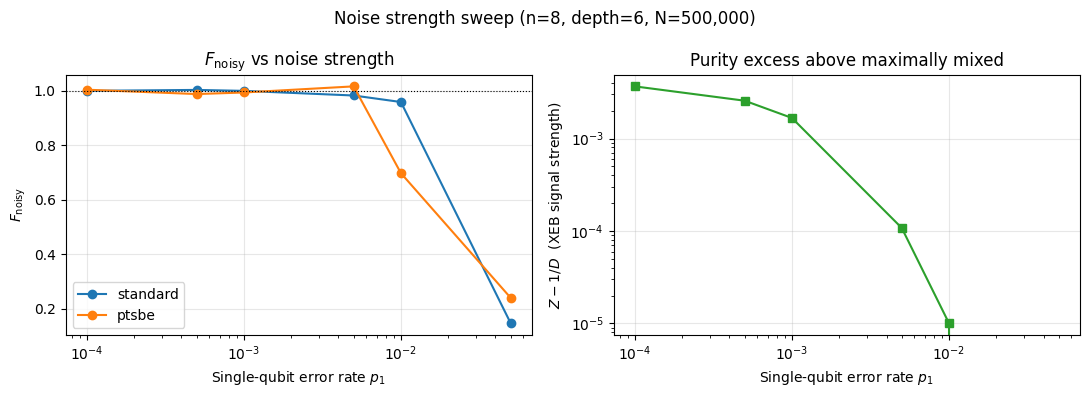

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

for method in ["standard", "ptsbe"]:
    ax1.semilogx(p1_values, noise_sweep[method], "o-", label=method)
ax1.axhline(1.0, color="k", ls=":", lw=0.8)
ax1.set_xlabel("Single-qubit error rate $p_1$")
ax1.set_ylabel("$F_{\\mathrm{noisy}}$")
ax1.set_title("$F_{\\mathrm{noisy}}$ vs noise strength")
ax1.legend()

signal = [z - 1/D for z in z_values]
ax2.loglog(p1_values, signal, "s-", color="C2")
ax2.set_xlabel("Single-qubit error rate $p_1$")
ax2.set_ylabel("$Z - 1/D$  (XEB signal strength)")
ax2.set_title("Purity excess above maximally mixed")

fig.suptitle(f"Noise strength sweep (n={n}, depth={depth}, N={N_SHOTS:,})", fontsize=12)
plt.tight_layout()
plt.show()

### Negative control

Demonstrate that $F_{\text{noisy}}$ detects trajectory selection bias in PTSBE. We compare four configurations at the same `max_trajectories` budget:

- **standard**: exact noisy sampling via `STD_TARGET` (baseline, $F_{\text{noisy}} \approx 1.0$).
- **Probabilistic**: `ProbabilisticSamplingStrategy` with default (proportional) shot allocation.
- **Prob + mult. weighted**: `ProbabilisticSamplingStrategy` with `MULTIPLICITY_WEIGHTED` shot allocation (the strategy used throughout this notebook).
- **Ordered**: `OrderedSamplingStrategy` deterministically selects the top-k highest-probability trajectories, systematically excluding high-error paths. This makes the output distribution artificially sharp and should drive $F_{\text{noisy}}$ well above 1.0.

A metric with discriminating power must clearly separate the ordered case from the others. The two probabilistic variants should both stay near 1.0, with multiplicity-weighted allocation tracking closest to the standard baseline.

In [19]:
n, depth = 8, 8
rng = np.random.default_rng(100)
gate_choices = generate_gate_choices(n, depth, rng)
kernel_no_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=False)
kernel_mz = build_xeb_circuit(n, depth, gate_choices, with_mz=True)

noise_model = build_noise_model()
p_dm = get_dm_diagonal(kernel_no_mz, noise_model, n, p_meas=0.01)

neg_ctrl = {}

result_std = run_noisy_sample(kernel_mz, noise_model, shots=N_SHOTS, method="standard")
f_std, _, _ = compute_f_noisy(p_dm, result_std, n)
neg_ctrl["standard"] = f_std

strategies = [
    ("Probabilistic",       cudaq.ptsbe.ProbabilisticSamplingStrategy(seed=42), None),
    ("Prob + mult. wt.", cudaq.ptsbe.ProbabilisticSamplingStrategy(seed=42), MULT_ALLOC),
    ("Ordered",             cudaq.ptsbe.OrderedSamplingStrategy(),              None),
]

print(f"Negative control (n={n}, depth={depth}, N={N_SHOTS:,}, max_traj={MAX_TRAJ})\n")
print(f"  {'standard':>20s}: F_noisy = {f_std:.4f}")
for label, strategy, alloc in strategies:
    cudaq.set_target(PTSBE_TARGET)
    kwargs = dict(
        noise_model=noise_model, shots_count=N_SHOTS,
        sampling_strategy=strategy, max_trajectories=MAX_TRAJ,
    )
    if alloc is not None:
        kwargs["shot_allocation"] = alloc
    result = cudaq.ptsbe.sample(kernel_mz, **kwargs)
    f, _, _ = compute_f_noisy(p_dm, result, n)
    neg_ctrl[label] = f
    print(f"  {label:>20s}: F_noisy = {f:.4f}")

Negative control (n=8, depth=8, N=500,000, max_traj=250)

          standard: F_noisy = 0.9967
     Probabilistic: F_noisy = 1.6107
           Ordered: F_noisy = 1.8460


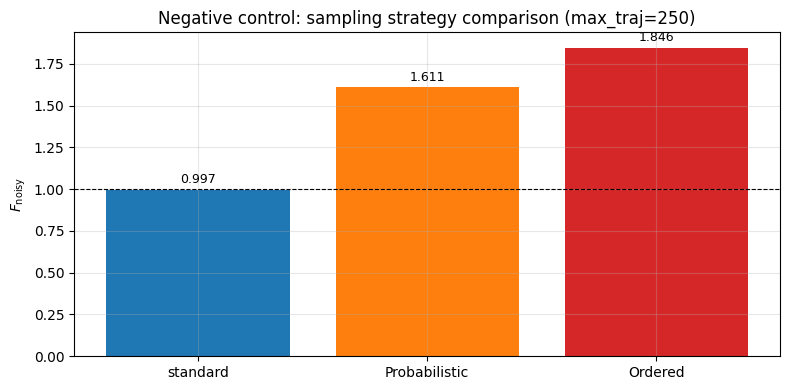

In [20]:
labels = list(neg_ctrl.keys())
vals = list(neg_ctrl.values())
colors = ["C0", "C1", "C2", "C3"]

fig, ax = plt.subplots()
bars = ax.bar(labels, vals, color=colors)
ax.axhline(1.0, color="k", ls="--", lw=0.8)
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width() / 2, v + 0.02,
            f"{v:.3f}", ha="center", va="bottom", fontsize=9)
ax.set_ylabel("$F_{\\mathrm{noisy}}$")
ax.set_title(f"Negative control: sampling strategy comparison (max_traj={MAX_TRAJ})")
ax.tick_params(axis="x", rotation=15)
plt.tight_layout()
plt.show()